In [1]:
source = 'sample_data/'

In [2]:
# From the raccoon tutorial
#https://github.com/datitran/raccoon_dataset/blob/master/xml_to_csv.py

# Used to convert xml files to csv files, takes in a path to xml files, returns Pandas dataframe
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    
    return xml_df

df = xml_to_csv(source)

In [51]:
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,201503.20150602.121659332.69206.orig.jpg,1360,1024,Substrate A,89,114,102,120
1,201503.20150602.121659332.69206.orig.jpg,1360,1024,Small shell hash,77,141,95,152
2,201503.20150602.121659332.69206.orig.jpg,1360,1024,sand dollar,492,335,521,365
3,201503.20150602.121659332.69206.orig.jpg,1360,1024,sand dollar,679,33,708,63
4,201503.20150602.121659332.69206.orig.jpg,1360,1024,sand dollar,451,333,480,363


sand dollar         3648
Substrate A           26
Small shell hash      11
Substrate B            3
Hermit crab            3
Scallop                2
Moon Snail             1
Whelk                  1
Name: class, dtype: int64


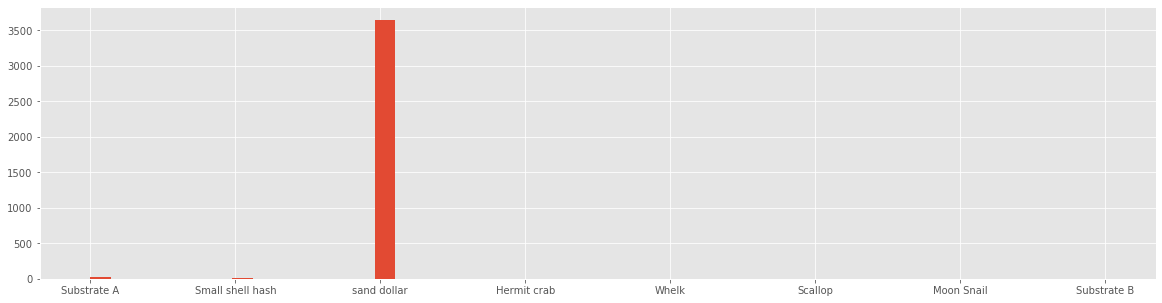

In [56]:
# View of the distribution
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize = (20, 5))
plt.hist(df['class'], align = 'mid', bins = 50);

print(df['class'].value_counts())

In [5]:
df.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [43]:
# for converting the csv/pandas dataframe into TFRecord format
# https://stackoverflow.com/questions/41402332/tensorflow-create-a-tfrecords-file-from-csv

import pandas as pd
import tensorflow as tf
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# The function takes in the all of the features of a single annotation instance as a list, and then also the label as its own variable
# it creates a TFRecord (see below cell for how the format looks, similar to XML)
def create_tf_example(features, label):

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[features[0].encode('utf-8')])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[1])])),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[2])])),
        'class':tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.encode('utf-8')])),
        'xmin':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[3])])),
        'ymin':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[4])])),
        'xmax':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[5])])),
        'ymax':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[6])])),
    }))
    return tf_example


In [57]:
# Loops through all of the rows in the pandas dataframe and individually converts each annotation instance into the TFRecord format
# note that this loop breaks after a single annotation just to provide an example. Remove the break when actually using!
# Saves/writes the output in root folder
with tf.python_io.TFRecordWriter("dataset.tfrecords") as writer:
    for index, row in df.iterrows():
        features = np.array(list(row[0:3].values) + list(row[4:].values))      # All of the features in the row, minus the class label
        label = row[3]                                                         # just the class label
        example = create_tf_example(features, label)                           # creates a TFRecord
        writer.write(example.SerializeToString())
        
        break                                                                  # for example, remove otherwise
writer.close()

In [58]:
# displays the converted annotation
example

features {
  feature {
    key: "class"
    value {
      bytes_list {
        value: "Substrate A"
      }
    }
  }
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "201503.20150602.121659332.69206.orig.jpg"
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 1024
      }
    }
  }
  feature {
    key: "width"
    value {
      int64_list {
        value: 1360
      }
    }
  }
  feature {
    key: "xmax"
    value {
      int64_list {
        value: 102
      }
    }
  }
  feature {
    key: "xmin"
    value {
      int64_list {
        value: 89
      }
    }
  }
  feature {
    key: "ymax"
    value {
      int64_list {
        value: 120
      }
    }
  }
  feature {
    key: "ymin"
    value {
      int64_list {
        value: 114
      }
    }
  }
}